In [296]:
import requests
from bs4 import BeautifulSoup
import csv
import pandas as pd
import re
import time
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import json
import numpy as np
from pathlib import Path

In [ ]:
# check out XML stuff

start_url = "https://www.macys.com/"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.0.0 Safari/537.36"
}
web_pull = requests.get(start_url, headers = headers)
soup = BeautifulSoup(web_pull.content, 'html.parser')
soup

In [ ]:
# get links from sub menu
categorylist = soup.find_all("a", {"class":"topCatLink"}, href = True)
categorylist

# make complete urls for categories
category_links = []
for category in categorylist:
    category_links.append('https://www.dillards.com' + category['href'])
category_links

# delete exlusives channel
del category_links[-1]
# delete kids channel bc throws error
del category_links[3]

# # # # create master list of all website links
subcategory_links = []
for category in category_links:
    web_pull = requests.get(category, headers = headers)
    soup = BeautifulSoup(web_pull.content, 'html.parser')
    subcategorylist = soup.find("h3", text = 'Category').find_next_sibling()
    subcategorylist = subcategorylist.find_all(href = True)
    for subcategory in subcategorylist:
        subcategory_links.append('https://www.dillards.com' + subcategory['href'])
subcategory_links

In [ ]:
# scrape all data **this cell will take a longggg time to run** (probably a half hour)
# took 23 minutes to scrape 90,000 rows. Not bad at all

# possible ideas, include the category in the scrape?
# get price working?



Product_Name = pd.DataFrame()
Product_Price = pd.DataFrame()
Brand_Name = pd.DataFrame()
for site in subcategory_links:
        web_pull = requests.get(site, headers = headers)
        soup = BeautifulSoup(web_pull.content, 'html.parser')

        try:
                last_page = soup.find('li', {'class':'page-item p-r-0'}).get('data-value')
        
        except:
                last_page = '0'
            
        last_page_num = int(last_page)
        for page in range(1,last_page_num+1):
                if page == 1:
                        url = site + '?pagenumber=' + str(page)
                else:
                        url = site + '?pageNumber=' + str(page) + '&pagenumber=1'
                
                web_pull2 = requests.get(url, headers = headers)
                soup2 = BeautifulSoup(web_pull2.content, 'html.parser')

                ## PRODUCT NAME
                product_name = [x.get_text() for x in soup2.find_all('span', {'class':'productName'})]
                name_data = pd.DataFrame(product_name)
                Product_Name = Product_Name.append(name_data)

                ## BRAND NAME
                brand_name = [x.get_text() for x in soup2.find_all('span', {'class':'brandName'})]
                brand_data = pd.DataFrame(brand_name)
                Brand_Name = Brand_Name.append(brand_data)

                ## PRODUCT NUMBER

                ## LIMITED AVAILABILITY TAG

                ## PRODUCT PRICE - STILL DEBUGGIN
                #product_price = [x.get_text() for x in soup2.find_all('span', {'class':'price'})]
                #price_data = pd.DataFrame(product_price)
                #Product_Price = Product_Price.append(price_data)



In [284]:
# CLEAN UP DATA SCRAPED
Product_Name = Product_Name.reset_index(drop = True)
Product_Name.rename(columns={Product_Name.columns[0]: 'Product'},inplace=True)
Brand_Name = Brand_Name.reset_index(drop = True)
Brand_Name.rename(columns={Brand_Name.columns[0]: 'Brand'},inplace=True)

False

In [282]:
# COMBINE AND CREATE DATAFRAME
dillards_products = pd.DataFrame()
dillards_products = pd.concat([Product_Name, Brand_Name], axis=1)
dillards_products

,Product,Brand
0,Ruffle Off-the-Shoulder Short Elbow Sleeve Col...,Xscape
1,Lela Bow Mock Neck Long Sleeve Sweater Dress,Antonio Melani
2,Stretch Crepe Crew Neck Tie Waist 3/4 Sleeve M...,Adrianna Papell
3,Short Sleeve Sequin Point Collar Mini Shift Dress,Every
4,Plisse Satin Ruffle Deep V-Neck Long Smocked C...,Chelsea & Violet
...,...,...
89653,Head To Toe AfterGlo Set,BeautyBio
89654,The Complete Glo Gift Set,BeautyBio
89655,Lights Out. Mask On. Set,BeautyBio
89656,Smashbox After The After Party Full-Size Lip D...,smashbox


In [281]:
# VISUALIZE AND CONSOLIDATE
total_num_products = dillards_products['Product'].count()
brand_split = dillards_products.groupby('Brand').count().sort_values(by = 'Product', ascending=False)
brand_split.rename(columns={brand_split.columns[0]: 'Product_Count'},inplace=True)
top_20_brands = brand_split.head(20)
top_20_brands['Product_Count'].astype(int)
top_20_brands['Percent_of_Total_Products'] = (top_20_brands['Product_Count'] / total_num_products) * 100
top_20_brands


/tmp/ipykernel_118/3690486713.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_20_brands['Percent_of_Total_Products'] = (top_20_brands['Product_Count'] / total_num_products) * 100


,Product_Count,Percent_of_Total_Products
Brand,,
Polo Ralph Lauren,1521,1.696446
Michael Kors,1318,1.470031
James Avery,1265,1.410917
Southern Living,1194,1.331727
Antigua,1175,1.310536
Lauren Ralph Lauren,1132,1.262576
The North Face,1017,1.134310
Calvin Klein,934,1.041736
kate spade new york,915,1.020545


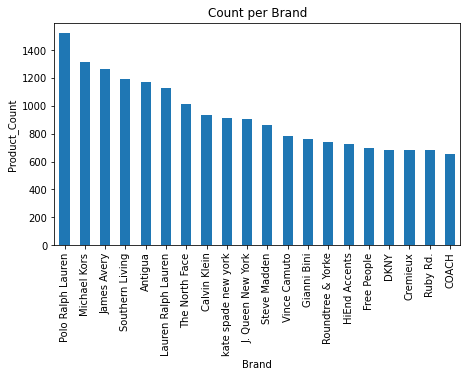

In [252]:
plt.subplot(221)
top_20_brands['Product_Count'].plot(kind='bar', title='Count per Brand', figsize=(16,9))
plt.xticks(rotation=90)
plt.xlabel('Brand')
plt.ylabel('Product_Count')

plt.show()

In [280]:
## READ TO CSV FILE
dillards_products.to_csv('dillard12_20')